Problem statement:

We have n gyrotrons which always stay in a user-defined order. Each gyrotron is input an angle and produces a gaussian. We also input the number of angles we want to sample. We input the wanted overall profile. We output the power and mirror angle for the n gyrotrons that best matches the input target.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, IntSlider
import ipywidgets as widgets

# # Use this magic command for interactive plots in JupyterLab/Jupyter Notebook
# %matplotlib widget

In [2]:
# Gaussian with height 5 and width 10
import numpy as np

x = np.linspace(0, 1, 100)
height = 1
width = 0.1  # Full width at half maximum (FWHM)
sigma = width / (2 * np.sqrt(2 * np.log(2)))
center = 0.04
#target_profile = height * np.exp(-0.5 * ((x - center) / sigma) ** 2)

height_2 = 0.5
width_2 = 0.1  # Full width at half maximum (FWHM)
sigma_2 = width_2 / (2 * np.sqrt(2 * np.log(2)))
center_2 = 0.5

target_profile_1 = height * np.exp(-0.5 * ((x - center) / sigma) ** 2) + height_2 * np.exp(-0.5 * ((x - center_2) / sigma_2) ** 2)

target_profile_2 = 1.5 * np.exp(-0.5 * ((x - 0.1) / 0.1) ** 2)



In [3]:
angle_options = np.linspace(100, 120, 20)
print(angle_options)
new_angles1 = np.array([105, 110, 115, 120])
print(np.array([angle_options[np.argmin(np.abs(angle_options - angle))] for angle in new_angles1]))


[100.         101.05263158 102.10526316 103.15789474 104.21052632
 105.26315789 106.31578947 107.36842105 108.42105263 109.47368421
 110.52631579 111.57894737 112.63157895 113.68421053 114.73684211
 115.78947368 116.84210526 117.89473684 118.94736842 120.        ]
[105.26315789 109.47368421 114.73684211 120.        ]


In [4]:
# new gyrotron optimizer
def generate_gaussian(angle, total_area):
    """
    Generates a Gaussian with 10 datapoints.
    The x axis goes from 0 to 1.
    The width (stddev) increases as the angle decreases.
    The center moves from 0 (angle=100) to 0.8 (angle=120).
    The total area under the curve is normalized to total_area.
    """
    n_points = 100
    x = np.linspace(0, 1, n_points)
    # Center moves linearly from 0 (angle=100) to 0.8 (angle=120)
    center = 0.8 + 0.8*(-angle + 100) / (120 - 100)
    # stddev proportional to angle (smaller angle = larger stddev)
    # Choose k so stddev is reasonable for the x range
    k = 1.0
    stddev = k / (angle - 92)
    gaussian = np.exp(-0.5 * ((x - center) / stddev) ** 2)
    area = np.trapz(gaussian, x)
    if area == 0:
        gaussian[:] = 0
    else:
        gaussian *= total_area / area
    return gaussian
    
def find_best_gyrotron_configuration_ordered(target_profile, n_gyrotrons=6, angle_options=np.linspace(100, 120, 100), 
                                            max_powers=[0.5, 0.5, 0.8, 0.4, 0.6, 0.6], power_supplies=[0, 0, 1, 2, 3, 3], previous_population=[], population_size=200, generations=10, mutation_rate=0.15, elite_size=20, inertia=0.2,
                                            prev_angles=None):
    """
    Find the best configuration of n_gyrotrons with individual power limits and ordered angles.
    Gyrotron 1 has lowest angle, Gyrotron 2 has next lowest, etc.
    
    Parameters:
    - target_profile: 1D array, the target profile to approximate
    - n_gyrotrons: int, number of gyrotrons to use (default 6)
    - angle_range: tuple, (min_angle, max_angle) for gyrotron angles
    - max_powers: list, maximum power for each gyrotron (if None, uses [1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    - power_supplies: list of power supplies for each gyrotron. 0,0,1,2,3,3 means that gyro 0 and 1 share a power supply, and gyro 5 and 6 share a power supply
    - inertia: float, the fraction of the population that is kept from the previous generation
    - prev_angles: list of angles from previous optimization to limit maximum rate of change

    Returns:
    - best_angles: list of optimal angles for each gyrotron (in ascending order)
    - best_powers: list of optimal power levels for each gyrotron
    - best_combination: sum of optimized gyrotron profiles
    - error: mean squared error between target and best combination
    - power_utilization: list of power utilization percentages for each gyrotron
    """
    
    # Set default power limits if not provided
    
    # Ensure we have the right number of power limits
    if len(max_powers) != n_gyrotrons:
        raise ValueError(f"max_powers must have {n_gyrotrons} elements, got {len(max_powers)}")
    n_power_supplies = len(np.unique(power_supplies))

    def calculate_powers_from_duty_cycles(duty_cycles, max_powers, power_supplies):
        # duty_cycles is a list of the duty cycles for each power supply
        # max_powers is a list of the maximum powers for each gyrotron
        # power_supplies is a list of the power supply that each gyrotron is connected to
        powers = np.zeros(n_gyrotrons)
       
        for which_gyro, which_power_supply in enumerate(power_supplies):
            powers[which_gyro] = duty_cycles[which_power_supply] * max_powers[which_gyro]
        return powers

    def calculate_error(angles, duty_cycles):
        """Calculate MSE between target and sum of gyrotron profiles"""
        combination_sum = np.zeros_like(target_profile)
        powers = calculate_powers_from_duty_cycles(duty_cycles, max_powers, power_supplies)
        for angle, power in zip(angles, powers):
            combination_sum += generate_gaussian(angle, power)
        mse = np.mean((target_profile - combination_sum) ** 2)
        return mse
    
    def check_angle_ordering(angles):
        """Check if angles are in ascending order"""
        return all(angles[i] <= angles[i+1] for i in range(len(angles)-1))

    def create_individual():
        """Create a random individual with ordered angles"""
        # Pick n_gyrotrons random angles from angle_options
        angles = np.random.choice(angle_options, n_gyrotrons)
        angles = np.sort(angles)  # Ensure ascending order
        
        # Generate duty cycles for each power supply
        duty_cycles = np.random.uniform(0, 1, n_power_supplies)
        return np.concatenate([angles, duty_cycles])
    
    def evaluate_individual(individual):
        """Evaluate fitness of an individual (lower is better)"""
        angles = individual[:n_gyrotrons]
        duty_cycles = individual[n_gyrotrons:]
        
        # Add penalty if angles are not in order (shouldn't happen with our creation method)
        if not check_angle_ordering(angles):
            return float('inf')
        
        return calculate_error(angles, duty_cycles)
    
    def crossover(parent1, parent2):
        duty_cycles_simple_crossover = False
        """Crossover that maintains angle ordering"""
        child1 = parent1.copy()
        child2 = parent2.copy()
        
        # For angles, we need to be careful to maintain ordering
        # We'll do a more sophisticated crossover
        angles1 = parent1[:n_gyrotrons]
        angles2 = parent2[:n_gyrotrons]
        
        # Create new angle sets by interpolating between parents
        alpha = np.random.random()
        new_angles1 = alpha * angles1 + (1 - alpha) * angles2
        new_angles2 = (1 - alpha) * angles1 + alpha * angles2

        # pick the angle closest from angle_options
        new_angles1 = np.array([angle_options[np.argmin(np.abs(angle_options - angle))] for angle in new_angles1])
        new_angles2 = np.array([angle_options[np.argmin(np.abs(angle_options - angle))] for angle in new_angles2])
        
        child1[:n_gyrotrons] = new_angles1
        child2[:n_gyrotrons] = new_angles2
        
        if duty_cycles_simple_crossover:
                    # Crossover for powers (simple uniform crossover)
            for i in range(n_gyrotrons, n_gyrotrons + n_power_supplies):
                if np.random.random() < 0.5:
                    child1[i], child2[i] = child2[i], child1[i]
        else:
            # Same crossover for duty cycles
            duty_cycles1 = parent1[n_gyrotrons:]
            duty_cycles2 = parent2[n_gyrotrons:]
            # use the same alpha too

            child1[n_gyrotrons:] = alpha * duty_cycles1 + (1 - alpha) * duty_cycles2
            child2[n_gyrotrons:] = (1 - alpha) * duty_cycles1 + alpha * duty_cycles2

            child1[n_gyrotrons:] = child1[n_gyrotrons:]
            child2[n_gyrotrons:] = child2[n_gyrotrons:]
        
        return child1, child2
    
    def mutate(individual):
        """Mutate while maintaining angle ordering"""
        mutated = individual.copy()
        
        # Mutate angles while maintaining order
        for i in range(n_gyrotrons):
            if np.random.random() < mutation_rate:
                # Generate new angle between the angle before and after
                if i == 0:
                    new_angle = np.random.uniform(angle_options[0], mutated[i+1])
                    new_angle = angle_options[np.argmin(np.abs(angle_options - new_angle))]
                elif i == n_gyrotrons - 1:
                    new_angle = np.random.uniform(mutated[i-1], angle_options[-1])
                    new_angle = angle_options[np.argmin(np.abs(angle_options - new_angle))]
                else:
                    new_angle = np.random.uniform(mutated[i-1], mutated[i+1])
                    new_angle = angle_options[np.argmin(np.abs(angle_options - new_angle))]
                mutated[i] = new_angle
        
        
        # Mutate powers
        for i in range(n_power_supplies):
            if np.random.random() < mutation_rate:
                mutated[n_gyrotrons + i] = np.random.uniform(0, 1)

        
        return mutated
    
    # Initialize population with inertia
    population = [create_individual() for _ in range(int(population_size*(1-inertia)))]
    if inertia > 0:
        population.extend(previous_population[:int(inertia*population_size)])
    
    best_error = float('inf')
    best_individual = None
    
    for generation in range(generations):
        # Evaluate population
        fitness_scores = [evaluate_individual(ind) for ind in population]
        
        # Find best individual
        min_fitness_idx = np.argmin(fitness_scores)
        if fitness_scores[min_fitness_idx] < best_error:
            best_error = fitness_scores[min_fitness_idx]
            best_individual = population[min_fitness_idx].copy()
        
        # Create new population
        new_population = []
        
        # Elitism: keep best individuals
        sorted_indices = np.argsort(fitness_scores)
        for i in range(elite_size):
            new_population.append(population[sorted_indices[i]].copy())
        
        # Generate offspring
        while len(new_population) < population_size:
            # Tournament selection
            parent1_idx = np.random.choice(population_size, size=5, replace=False)
            parent1 = population[np.argmin([fitness_scores[i] for i in parent1_idx])]
            
            parent2_idx = np.random.choice(population_size, size=5, replace=False)
            parent2 = population[np.argmin([fitness_scores[i] for i in parent2_idx])]
            
            # Crossover
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]
        
        if generation == generations - 1:
            print(f"Generation {generation}: Best error = {best_error:.6f}")
    
    # Extract results
    best_angles = best_individual[:n_gyrotrons].tolist()
    best_duty_cycles = best_individual[n_gyrotrons:].tolist()

    # Limit change in angles to within 1 degree of previous angles if provided
    if prev_angles is not None:
        for i in range(n_gyrotrons):
            if best_angles[i] < prev_angles[i] - 1:
                best_angles[i] = prev_angles[i] - 1
            elif best_angles[i] > prev_angles[i] + 1:
                best_angles[i] = prev_angles[i] + 1

    best_powers = calculate_powers_from_duty_cycles(best_duty_cycles, max_powers, power_supplies)

# Calculate final result
    best_combination = np.zeros_like(target_profile)
    for angle, power in zip(best_angles, best_powers):
        best_combination += generate_gaussian(angle, power)
    
    final_error = calculate_error(best_angles, best_powers)
    
    # Calculate power utilization
    power_utilization = [(power / max_power) * 100 for power, max_power in zip(best_powers, max_powers)]
    
    # Verify angle ordering
    if not check_angle_ordering(best_angles):
        print("WARNING: Final angles are not in ascending order!")
    
    return best_angles, best_powers, best_combination, final_error, power_utilization, population


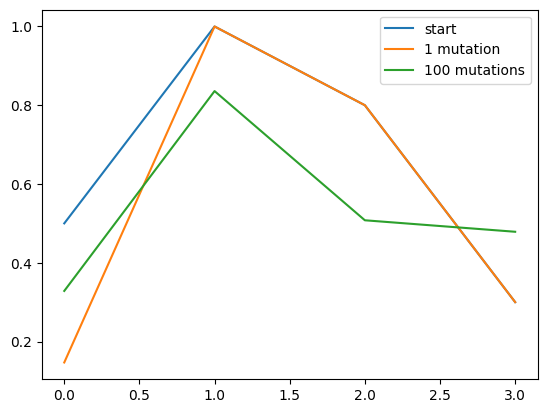

In [5]:
# random testing of functions
n_gyrotrons = 6
n_power_supplies = 4
mutation_rate = 0.5
angle_options = np.linspace(100, 120, 20)
angle_range = (100, 120)
max_powers = [0.8, 0.5, 0.2, 0.3, 0.7, 0.8]
power_supplies = [0, 0, 1, 2, 3, 3]
individual = [103, 105, 110, 115, 117, 118, 0.5, 1, 0.8, 0.3]


def calculate_powers_from_duty_cycles(duty_cycles, max_powers, power_supplies):
    # duty_cycles is a list of the duty cycles for each power supply
    # max_powers is a list of the maximum powers for each gyrotron
    # power_supplies is a list of the power supply that each gyrotron is connected to
    powers = np.zeros(n_gyrotrons)
    
    for which_gyro, which_power_supply in enumerate(power_supplies):
        powers[which_gyro] = duty_cycles[which_power_supply] * max_powers[which_gyro]
    return powers

def mutate(individual):
    """Mutate while maintaining angle ordering"""
    mutated = individual.copy()
    
    # Mutate angles while maintaining order
    for i in range(n_gyrotrons):
        if np.random.random() < mutation_rate:
            # Generate new angle between the angle before and after
            if i == 0:
                new_angle = np.random.uniform(angle_range[0], mutated[i+1])
            elif i == n_gyrotrons - 1:
                new_angle = np.random.uniform(mutated[i-1], angle_range[1])
            else:
                new_angle = np.random.uniform(mutated[i-1], mutated[i+1])
            mutated[i] = new_angle
    
    
    # Mutate powers
    for i in range(n_power_supplies):
        if np.random.random() < mutation_rate:
            mutated[n_gyrotrons + i] = np.random.uniform(0, 1)

    
    return mutated

mutated_individual = mutate(individual)
plt.plot(individual[n_gyrotrons:], label='start')
plt.plot(mutated_individual[n_gyrotrons:], label='1 mutation')
for _ in range(100):
    mutated_individual = mutate(mutated_individual)

plt.plot(mutated_individual[n_gyrotrons:], label='100 mutations')
plt.legend()
plt.show()



Testing gyrotron configuration with angle ordering constraint...
Target profile shape: (100,)
Generation 9: Best error = 0.004224

Results with angle ordering constraint:
Best angles (ordered): ['107.00', '108.00', '118.00', '119.00', '119.00', '120.00']
Best powers: ['0.027', '0.040', '0.044', '0.032', '0.015', '0.010']
Mean Squared Error: 0.042670

Gyrotron Configuration (with angle ordering):
  Gyrotron 1: Angle = 107.00°, Power = 0.027/0.1 (33.2% utilized)
  Gyrotron 2: Angle = 108.00°, Power = 0.040/0.1 (33.2% utilized)
  Gyrotron 3: Angle = 118.00°, Power = 0.044/0.2 (17.6% utilized)
  Gyrotron 4: Angle = 119.00°, Power = 0.032/0.2 (17.6% utilized)
  Gyrotron 5: Angle = 119.00°, Power = 0.015/0.3 (4.8% utilized)
  Gyrotron 6: Angle = 120.00°, Power = 0.010/0.2 (4.8% utilized)

Angle ordering verification:
  ✓ G1 (107.00°) ≤ G2 (108.00°)
  ✓ G2 (108.00°) ≤ G3 (118.00°)
  ✓ G3 (118.00°) ≤ G4 (119.00°)
  ✓ G4 (119.00°) ≤ G5 (119.00°)
  ✓ G5 (119.00°) ≤ G6 (120.00°)

Power utilizatio

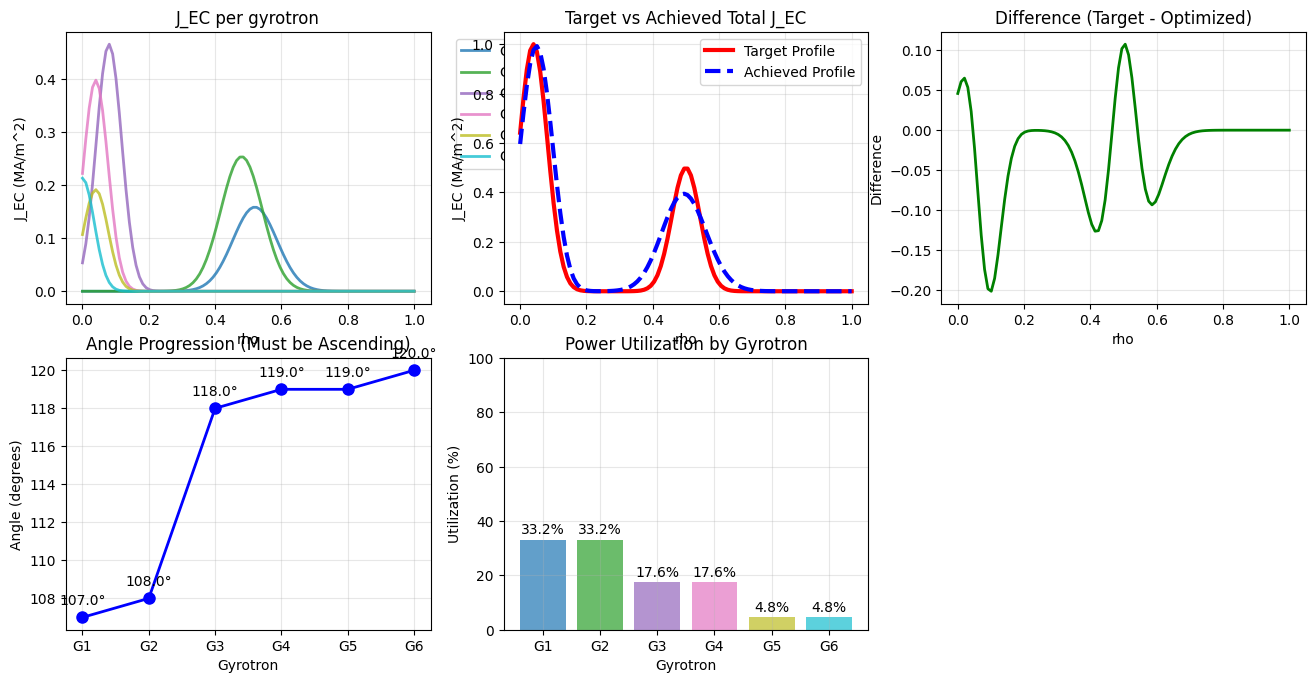

In [6]:
# Test the new function with angle ordering constraint
print("Testing gyrotron configuration with angle ordering constraint...")
print(f"Target profile shape: {target_profile_1.shape}")

# Use the same power limits as before
custom_max_powers = [0.08, 0.12, 0.25, 0.18, 0.32, 0.20]
power_supplies = [0, 0, 1, 2, 3, 3]
settings = {
    'population_size': 200,
    'generations': 10,
    'mutation_rate': 0.15,
    'elite_size': 20,
    'inertia': 0
}
angle_options = np.linspace(100, 120, 21)
# Run the optimization with ordering constraint
best_angles_ordered, best_powers_ordered, best_combination_ordered, error_ordered, power_utilization_ordered, population_ordered = find_best_gyrotron_configuration_ordered(
    target_profile_1, 
    n_gyrotrons=6, 
    angle_options=angle_options, 
    max_powers=custom_max_powers,
    power_supplies=power_supplies,
    **settings
)

print(f"\nResults with angle ordering constraint:")
print(f"Best angles (ordered): {[f'{angle:.2f}' for angle in best_angles_ordered]}")
print(f"Best powers: {[f'{power:.3f}' for power in best_powers_ordered]}")
print(f"Mean Squared Error: {error_ordered:.6f}")

print(f"\nGyrotron Configuration (with angle ordering):")
for i, (angle, power, max_power, utilization) in enumerate(zip(best_angles_ordered, best_powers_ordered, custom_max_powers, power_utilization_ordered)):
    print(f"  Gyrotron {i+1}: Angle = {angle:.2f}°, Power = {power:.3f}/{max_power:.1f} ({utilization:.1f}% utilized)")

# Verify angle ordering
print(f"\nAngle ordering verification:")
for i in range(len(best_angles_ordered)-1):
    if best_angles_ordered[i] <= best_angles_ordered[i+1]:
        print(f"  ✓ G{i+1} ({best_angles_ordered[i]:.2f}°) ≤ G{i+2} ({best_angles_ordered[i+1]:.2f}°)")
    else:
        print(f"  ✗ G{i+1} ({best_angles_ordered[i]:.2f}°) > G{i+2} ({best_angles_ordered[i+1]:.2f}°) - VIOLATION!")

print(f"\nPower utilization summary:")
print(f"  Average utilization: {np.mean(power_utilization_ordered):.1f}%")
print(f"  Max utilization: {max(power_utilization_ordered):.1f}%")
print(f"  Min utilization: {min(power_utilization_ordered):.1f}%")
# Visualize the results with angle ordering constraint
plt.figure(figsize=(16, 12))

# Prepare x axis from 0 to 1
x = np.linspace(0, 1, len(target_profile_1))

# Plot individual gyrotron profiles with ordered angles
plt.subplot(3, 3, 1)
colors = plt.cm.tab10(np.linspace(0, 1, 6))
for i, (angle, power, max_power) in enumerate(zip(best_angles_ordered, best_powers_ordered, custom_max_powers)):
    profile = generate_gaussian(angle, power)
    plt.plot(x, profile, color=colors[i], alpha=0.8, linewidth=2, 
             label=f'G{i+1}: {angle:.1f}°, J_EC={power:.2f}/{max_power:.2f}')
plt.title('J_EC per gyrotron')
plt.xlabel('rho')
plt.ylabel('J_EC (MA/m^2)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot target vs best combination
plt.subplot(3, 3, 2)
plt.plot(x, target_profile_1, 'r-', linewidth=3, label='Target Profile')
plt.plot(x, best_combination_ordered, 'b--', linewidth=3, label='Achieved Profile')
plt.title('Target vs Achieved Total J_EC')
plt.xlabel('rho')
plt.ylabel('J_EC (MA/m^2)')
# add a vertical line at 0.04 and at 0.3
plt.legend()
plt.grid(True, alpha=0.3)

# Plot difference
plt.subplot(3, 3, 3)
difference = target_profile_1 - best_combination_ordered
plt.plot(x, difference, 'g-', linewidth=2)
plt.title('Difference (Target - Optimized)')
plt.xlabel('rho')
plt.ylabel('Difference')
plt.grid(True, alpha=0.3)

# Plot angle progression
plt.subplot(3, 3, 4)
gyrotron_labels = [f'G{i+1}' for i in range(6)]
plt.plot(gyrotron_labels, best_angles_ordered, 'o-', linewidth=2, markersize=8, color='blue')
plt.title('Angle Progression (Must be Ascending)')
plt.xlabel('Gyrotron')
plt.ylabel('Angle (degrees)')
plt.grid(True, alpha=0.3)
for i, angle in enumerate(best_angles_ordered):
    plt.text(i, angle + 0.5, f'{angle:.1f}°', ha='center', va='bottom')

# Plot power utilization
plt.subplot(3, 3, 5)
bars = plt.bar(gyrotron_labels, power_utilization_ordered, color=colors, alpha=0.7)
plt.title('Power Utilization by Gyrotron')
plt.xlabel('Gyrotron')
plt.ylabel('Utilization (%)')
plt.ylim(0, 100)
for i, (bar, util) in enumerate(zip(bars, power_utilization_ordered)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{util:.1f}%', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

RUN MULTITIMESTEP SIMULATION

In [23]:
n_timesteps = 100
target_profiles = []
x = np.linspace(0, 1, 100)
height = 8
width = 0.1  # Full width at half maximum (FWHM)
sigma = width / (2 * np.sqrt(2 * np.log(2)))
center = 0.04
#target_profile = height * np.exp(-0.5 * ((x - center) / sigma) ** 2)

height_2 = 2.5
width_2 = 0.3  # Full width at half maximum (FWHM)
sigma_2 = width_2 / (2 * np.sqrt(2 * np.log(2)))
center_2 = 0.7

height_3 = 5.5
width_3 = 0.2  # Full width at half maximum (FWHM)
sigma_3 = width_3 / (2 * np.sqrt(2 * np.log(2)))
center_3 = 0.4

height_4 = 7.0
width_4 = 0.4  # Full width at half maximum (FWHM)
sigma_4 = width_4 / (2 * np.sqrt(2 * np.log(2)))
center_4 = 0.05

target_profile_1 = height * np.exp(-0.5 * ((x - center) / sigma) ** 2) + height_2 * np.exp(-0.5 * ((x - center_2) / sigma_2) ** 2)

target_profile_2 = 7.5 * np.exp(-0.5 * ((x - 0.1) / 0.1) ** 2)

target_profile_3 = height * np.exp(-0.5 * ((x - center) / sigma) ** 2) + height_2 * np.exp(-0.5 * ((x - center_2) / sigma_2) ** 2) + height_3 * np.exp(-0.5 * ((x - center_3) / sigma_3) ** 2)

def target_profile_4_func(t):
    return height_4 * np.exp(-0.5 * ((x - (center_4+(0.01*t))) / sigma_4) ** 2)


for timestep in range(n_timesteps):
    if timestep < n_timesteps / 5:
        target_profile = target_profile_1
    elif timestep < 2 * n_timesteps / 5:
        target_profile = target_profile_2
    elif timestep < 3 * n_timesteps / 5:
        target_profile = target_profile_3
    else:
        target_profile = target_profile_4_func(timestep - 3 * n_timesteps / 5)
    target_profiles.append(target_profile)

In [24]:
max_powers = [0.5, 0.5, 0.8, 0.4, 0.6, 0.6]
n_gyrotrons = 6
angle_options = np.linspace(100, 120, 1000)
power_supplies = [0, 0, 1, 2, 3, 3]
settings = {
    'population_size': 200,
    'generations': 10,
    'mutation_rate': 0.15,
    'elite_size': 20,
    'inertia': 0.2
}
def create_individual():
    """Create a random individual with ordered angles"""
    # Pick n_gyrotrons random angles from angle_options
    angles = np.random.choice(angle_options, n_gyrotrons)
    angles = np.sort(angles)  # Ensure ascending order
    
    # Generate duty cycles for each power supply
    duty_cycles = np.random.uniform(0, 1, len(np.unique(power_supplies)))
    return np.concatenate([angles, duty_cycles])
previous_population = [create_individual() for _ in range(settings['population_size'])]

optimization_vs_time = {}
prev_angles = previous_population[0][:n_gyrotrons]
for timestep in range(n_timesteps):
    optimization_vs_time[timestep] = find_best_gyrotron_configuration_ordered(
        target_profiles[timestep], 
        n_gyrotrons=6, 
        previous_population=previous_population,
        angle_options=angle_options, 
        max_powers=max_powers,
        power_supplies=power_supplies,
        prev_angles=prev_angles,
        **settings
    )
    previous_population = optimization_vs_time[timestep][5]
    prev_angles = optimization_vs_time[timestep][0]


Generation 9: Best error = 0.014340
Generation 9: Best error = 0.003276
Generation 9: Best error = 0.002161
Generation 9: Best error = 0.002058
Generation 9: Best error = 0.001412
Generation 9: Best error = 0.001322
Generation 9: Best error = 0.001171
Generation 9: Best error = 0.000825
Generation 9: Best error = 0.000626
Generation 9: Best error = 0.000622
Generation 9: Best error = 0.000622
Generation 9: Best error = 0.000595
Generation 9: Best error = 0.000574
Generation 9: Best error = 0.000565
Generation 9: Best error = 0.000551
Generation 9: Best error = 0.000549
Generation 9: Best error = 0.000549
Generation 9: Best error = 0.000548
Generation 9: Best error = 0.000548
Generation 9: Best error = 0.000544
Generation 9: Best error = 0.076775
Generation 9: Best error = 0.028059
Generation 9: Best error = 0.023352
Generation 9: Best error = 0.018907
Generation 9: Best error = 0.017987
Generation 9: Best error = 0.017741
Generation 9: Best error = 0.017708
Generation 9: Best error = 0

PLOT TIMETRACE OF TOTAL DEPOSITION

In [ ]:
def plot_temperature_profile(time_index):
    """
    Plots the temperature profile at a specific time step.
    This function will be controlled by the slider.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, target_profiles[time_index], 'r-', linewidth=3, label='Target Profile')
    ax.plot(x, optimization_vs_time[time_index][2], 'b--', linewidth=3, label='Achieved Profile')
    ax.set_ylim(np.min(target_profiles[0]), np.max(target_profiles[0]) + 0.5)
    ax.set_title(f'Target vs Achieved Total J_EC at Time Step: {time_index}')
    ax.set_xlabel('rho')
    ax.set_ylabel('Power density')
    ax.legend()
    ax.grid(True)
    plt.show()

# Create a slider widget for time index with continuous_update=True
time_slider = IntSlider(
    min=0,
    max=n_timesteps - 1,
    step=1,
    value=0,
    description='Time Step',
    continuous_update=True  # Changed to True for continuous update
)

# Use the interact function to link the slider to the plotting function
interactive_plot = interactive(plot_temperature_profile, time_index=time_slider)
display(interactive_plot)

# ----- New script to export an animated GIF from the data -----
import matplotlib.animation as animation

def save_temperature_profiles_gif(filename="temperature_profiles.gif", fps=10):
    """
    Creates and saves an animated GIF sweeping through all temperature profiles.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    line_target, = ax.plot([], [], 'r-', linewidth=3, label='Target Profile')
    line_achieved, = ax.plot([], [], 'b--', linewidth=3, label='Achieved Profile')
    ax.set_ylim(np.min(target_profiles[0]), np.max(target_profiles[0]) + 0.5)
    ax.set_xlim(x[0], x[-1])
    ax.set_xlabel('rho')
    ax.set_ylabel('Power density')
    ax.legend()
    ax.grid(True)

    def init():
        line_target.set_data([], [])
        line_achieved.set_data([], [])
        ax.set_title("Target vs Achieved Total J_EC")
        return line_target, line_achieved

    def update(frame):
        line_target.set_data(x, target_profiles[frame])
        line_achieved.set_data(x, optimization_vs_time[frame][2])
        ax.set_title(f'Target vs Achieved Total J_EC at Time Step: {frame}')
        return line_target, line_achieved

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=n_timesteps,
        init_func=init,
        blit=True
    )
    ani.save(filename, writer='pillow', fps=fps)
    plt.close(fig)
    print(f"GIF saved as {filename}")

# Example usage:
# This will save an animated gif
save_temperature_profiles_gif()


interactive(children=(IntSlider(value=0, description='Time Step', max=99), Output()), _dom_classes=('widget-in…

GIF saved as temperature_profiles.gif


PLOT TIMETRACE OF EVERYTHING

In [25]:
def plot_everything(time_index):
    best_angles_ordered, best_powers_ordered, best_combination_ordered, final_error, power_utilization_ordered, population = optimization_vs_time[time_index]
    plt.figure(figsize=(16, 12))

    # Prepare x axis from 0 to 1
    x = np.linspace(0, 1, len(target_profiles[time_index]))

    # Plot individual gyrotron profiles with ordered angles
    plt.subplot(3, 3, 1)
    colors = plt.cm.tab10(np.linspace(0, 1, 6))
    for i, (angle, power, max_power) in enumerate(zip(best_angles_ordered, best_powers_ordered, custom_max_powers)):
        profile = generate_gaussian(angle, power)
        plt.plot(x, profile, color=colors[i], alpha=0.8, linewidth=2, 
                label=f'G{i+1}: {angle:.1f}°, J_EC={power:.2f}/{max_power:.2f}')
    plt.title('J_EC per gyrotron')
    plt.xlabel('rho')
    plt.ylabel('J_EC (MA/m^2)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot target vs best combination
    plt.subplot(3, 3, 2)
    plt.plot(x, target_profiles[time_index], 'r-', linewidth=3, label='Target Profile')
    plt.plot(x, best_combination_ordered, 'b--', linewidth=3, label='Achieved Profile')
    plt.title('Target vs Achieved Total J_EC')
    plt.xlabel('rho')
    plt.ylabel('J_EC (MA/m^2)')
    # add a vertical line at 0.04 and at 0.3
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot difference
    plt.subplot(3, 3, 3)
    difference = target_profiles[time_index] - best_combination_ordered
    plt.plot(x, difference, 'g-', linewidth=2)
    plt.title('Difference (Target - Optimized)')
    plt.xlabel('rho')
    plt.ylabel('Difference')
    plt.grid(True, alpha=0.3)

    # Plot angle progression
    plt.subplot(3, 3, 4)
    gyrotron_labels = [f'G{i+1}' for i in range(6)]
    plt.plot(gyrotron_labels, best_angles_ordered, 'o-', linewidth=2, markersize=8, color='blue')
    plt.title('Angle Progression (Must be Ascending)')
    plt.xlabel('Gyrotron')
    plt.ylabel('Angle (degrees)')
    plt.grid(True, alpha=0.3)
    for i, angle in enumerate(best_angles_ordered):
        plt.text(i, angle + 0.5, f'{angle:.1f}°', ha='center', va='bottom')

    # Plot power utilization
    plt.subplot(3, 3, 5)
    bars = plt.bar(gyrotron_labels, power_utilization_ordered, color=colors, alpha=0.7)
    plt.title('Power Utilization by Gyrotron')
    plt.xlabel('Gyrotron')
    plt.ylabel('Utilization (%)')
    plt.ylim(0, 100)
    for i, (bar, util) in enumerate(zip(bars, power_utilization_ordered)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{util:.1f}%', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)
    plt.show()


# Create a slider widget for time index with continuous_update=True
time_slider = IntSlider(
    min=0,
    max=n_timesteps - 1,
    step=1,
    value=0,
    description='Time Step',
    continuous_update=True  # Changed to True for continuous update
)

# Use the interact function to link the slider to the plotting function
interactive_plot = interactive(plot_everything, time_index=time_slider)
display(interactive_plot)

# ----- Fixed script to export an animated GIF from the data -----
import matplotlib.animation as animation

def save_plot_everything_gif(filename="gyrotron_full_animation.gif", fps=4):
    """
    Creates and saves an animated GIF using the same plots as in plot_everything for all time steps.
    Slowed down animation by reducing default fps from 10 to 4.
    """
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt
    import numpy as np

    images = []
    for time_index in range(n_timesteps):
        fig = plt.figure(figsize=(16, 12))
        gs = gridspec.GridSpec(3, 3)
        x = np.linspace(0, 1, len(target_profiles[time_index]))
        # Target vs Achieved power profile
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(x, target_profiles[time_index], 'r-', linewidth=3, label='Target Profile')
        ax1.plot(x, optimization_vs_time[time_index][2], 'b--', linewidth=3, label='Achieved Profile')
        ax1.set_title('Target vs Achieved Total J_EC')
        ax1.set_xlabel('rho')
        ax1.set_ylabel('Power density')
        ax1.set_ylim(0, 8.0)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Optimized per-gyrotron power (make sure [3] is a 2D structure)
        ax2 = fig.add_subplot(gs[0, 1])
        best_angles_ordered = optimization_vs_time[time_index][0]
        best_powers_ordered = optimization_vs_time[time_index][1]
        best_combination_ordered = optimization_vs_time[time_index][2]
        power_utilization_ordered = optimization_vs_time[time_index][4]

        gyrotron_power = optimization_vs_time[time_index][3]
        for i, (angle, power, max_power) in enumerate(zip(best_angles_ordered, best_powers_ordered, custom_max_powers)):
            profile = generate_gaussian(angle, power)
            ax2.plot(x, profile, linewidth=2, label=f'G{i+1}: {angle:.1f}°, DC={power_utilization_ordered[i]:.2f}%')
        ax2.set_title('Power by Individual Gyrotrons')
        ax2.set_xlabel('rho')
        ax2.set_ylabel('Power density')
        ax2.set_ylim(0, 8.0)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Difference plot
        ax3 = fig.add_subplot(gs[0, 2])
        difference = target_profiles[time_index] - best_combination_ordered
        ax3.plot(x, difference, 'g-', linewidth=2)
        ax3.set_title('Difference (Target - Optimized)')
        ax3.set_xlabel('rho')
        ax3.set_ylabel('Difference')
        ax3.set_ylim(-1., 1.)
        ax3.grid(True, alpha=0.3)

        # Angle progression
        ax4 = fig.add_subplot(gs[1, 0])
        gyrotron_labels = [f'G{i+1}' for i in range(6)]
        best_angles_ordered = optimization_vs_time[time_index][0]
        ax4.plot(gyrotron_labels, best_angles_ordered, 'o-', linewidth=2, markersize=8, color='blue')
        ax4.set_title('Poloidal Angle for each Gyrotron')
        ax4.set_xlabel('Gyrotron')
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_ylim(98, 120)
        ax4.grid(True, alpha=0.3)
        for i, angle in enumerate(best_angles_ordered):
            ax4.text(i, angle + 0.5, f'{angle:.1f}°', ha='center', va='bottom')

        # Power Utilization bar plot
        ax5 = fig.add_subplot(gs[1, 1])
        
        if 'colors' in globals():
            _bars_colors = colors
        else:
            _bars_colors = plt.cm.viridis(np.linspace(0, 1, 6))
        bars = ax5.bar(gyrotron_labels, power_utilization_ordered, color=_bars_colors, alpha=0.7)
        ax5.set_title('Power Utilization by Gyrotron')
        ax5.set_xlabel('Gyrotron')
        ax5.set_ylabel('Utilization (%)')
        ax5.set_ylim(0, 100)
        for i, (bar, util) in enumerate(zip(bars, power_utilization_ordered)):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                     f'{util:.1f}%', ha='center', va='bottom')
        ax5.grid(True, alpha=0.3)

        # Supertitle
        fig.suptitle(f'Gyrotron Optimization Visualization - Time Step: {time_index}', fontsize=18)

        # Remove unused subplots
        for idx in [gs[1,2], gs[2,0], gs[2,1], gs[2,2]]:
            fig.add_subplot(idx).set_axis_off()


        fig.tight_layout(rect=[0, 0, 1, 0.97])
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(img)
        plt.close(fig)

    import imageio
    imageio.mimsave(filename, images, fps=fps)
    print(f"GIF saved as {filename}")

# Example usage:
save_plot_everything_gif()


interactive(children=(IntSlider(value=0, description='Time Step', max=99), Output()), _dom_classes=('widget-in…

/var/folders/gj/fx72q8gd497636f9415pl1wh0000gn/T/ipykernel_92636/353965759.py:176: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved as gyrotron_full_animation.gif


In [26]:
def save_plot_powers(filename="gyrotron_power_animation.gif", fps=4):
    """
    Creates and saves an animated GIF using the same plots as in plot_everything for all time steps.
    Slowed down animation by reducing default fps from 10 to 4.
    """
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt
    import numpy as np

    images = []
    for time_index in range(n_timesteps):
        fig = plt.figure(figsize=(16, 6))
        gs = gridspec.GridSpec(1, 2)
        x = np.linspace(0, 1, len(target_profiles[time_index]))
        # Target vs Achieved power profile
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(x, target_profiles[time_index], 'r-', linewidth=3, label='Target Profile')
        ax1.plot(x, optimization_vs_time[time_index][2], 'b--', linewidth=3, label='Achieved Profile')
        ax1.set_title('Target vs Achieved Total J_EC')
        ax1.set_xlabel('rho')
        ax1.set_ylabel('Power density')
        ax1.set_ylim(0, 8.0)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Optimized per-gyrotron power (make sure [3] is a 2D structure)
        ax2 = fig.add_subplot(gs[0, 1])
        best_angles_ordered = optimization_vs_time[time_index][0]
        best_powers_ordered = optimization_vs_time[time_index][1]
        best_combination_ordered = optimization_vs_time[time_index][2]
        power_utilization_ordered = optimization_vs_time[time_index][4]

        gyrotron_power = optimization_vs_time[time_index][3]
        for i, (angle, power, max_power) in enumerate(zip(best_angles_ordered, best_powers_ordered, custom_max_powers)):
            profile = generate_gaussian(angle, power)
            ax2.plot(x, profile, linewidth=2, label=f'G{i+1}: {angle:.1f}°, DC={power_utilization_ordered[i]:.2f}%')
        ax2.set_title('Power by Individual Gyrotrons')
        ax2.set_xlabel('rho')
        ax2.set_ylabel('Power density')
        ax2.set_ylim(0, 8.)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Supertitle
        fig.suptitle(f'Gyrotron Optimization Visualization - Time Step: {time_index}', fontsize=18)


        fig.tight_layout(rect=[0, 0, 1, 0.97])
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(img)
        plt.close(fig)

    import imageio
    imageio.mimsave(filename, images, fps=fps)
    print(f"GIF saved as {filename}")

# Example usage:
save_plot_powers()

/var/folders/gj/fx72q8gd497636f9415pl1wh0000gn/T/ipykernel_92636/3353884830.py:50: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved as gyrotron_power_animation.gif
